# **Salary prediction assignment**

Author: Lily He

# **Loading libraries and data**

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#import libraries，fig size setting
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from warnings import filterwarnings
filterwarnings('ignore')

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [15]:
#files location
path = '/content/drive/MyDrive/data/'
train_features = path+'train_features.csv'
train_salaries = path+'train_salaries.csv'
test_features = path+'test_features.csv'

In [16]:
#read train features, train salaries and test features
df = pd.read_csv(train_features,sep=",")
df_slry = pd.read_csv(train_salaries,sep=",")
df_output = pd.read_csv(test_features,sep=",")
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [19]:
#make a copy of test_features data set
df_output2 = df_output

# **Reviewing the data**

In [20]:
print('【tcheck NA for train fatures data set】')
print(df.isna().sum())
print("【tcheck NA for train salary data set】")
print(df_slry.isna().sum())
print('【tcheck NA for test fatures data set】')
print(df_output.isna().sum())

【tcheck NA for train fatures data set】
jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64
【tcheck NA for train salary data set】
jobId     0
salary    0
dtype: int64
【tcheck NA for test fatures data set】
jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64


In [21]:
#Check number of unique for each col, to see if there is any prolem especially for categorical variables
df_list = {'df','df_slry','df_output'}
for df_name in df_list:
  print('【train features nunique for '+df_name+'】')
  mycode = 'print('+ df_name+'.nunique())'
  exec(mycode)

【train features nunique for df_output】
jobId                  1000000
companyId                   63
jobType                      8
degree                       5
major                        9
industry                     7
yearsExperience             25
milesFromMetropolis        100
dtype: int64
【train features nunique for df】
jobId                  1000000
companyId                   63
jobType                      8
degree                       5
major                        9
industry                     7
yearsExperience             25
milesFromMetropolis        100
dtype: int64
【train features nunique for df_slry】
jobId     1000000
salary        280
dtype: int64


SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64


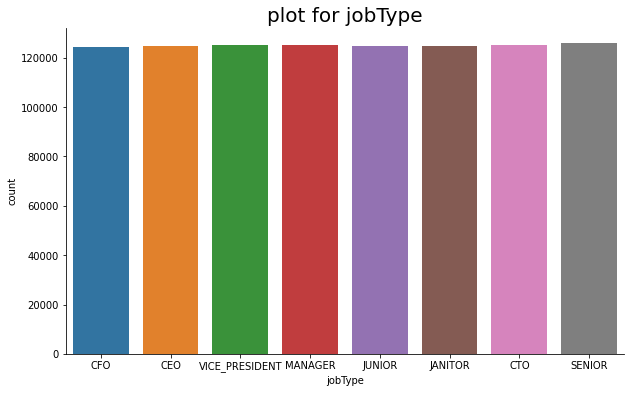

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64


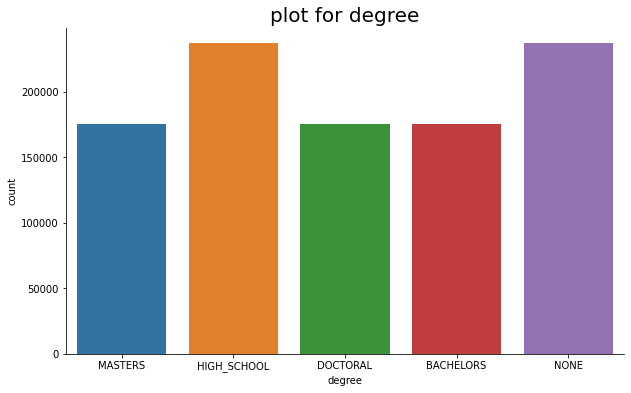

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64


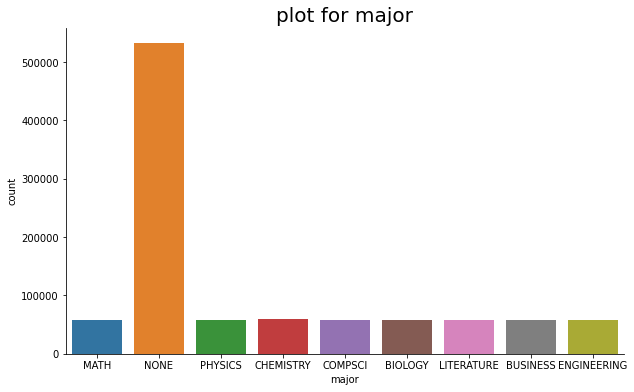

WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64


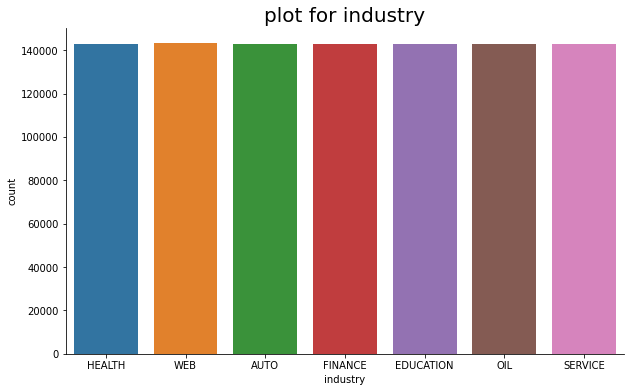

In [22]:
#get categorical and numeric variables name separately
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
# unique classes and their frequencies in categorical variables 
for i in cat_cols[2:6]:

    print(df[i].value_counts())
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x=df[i], data=df, ax=ax)
    plt.title('plot for '+i, fontdict={'fontsize': 20})
    plt.show()



In [23]:
# gater how many 'NONE' value, we consider NONE as other categorie, so we just keep them
df_none = pd.DataFrame(columns=['colName','total_None','percent_None'])
for x in df.columns[0:8]:
    total_None = sum(df[x]=='NONE')
    percent_None= round(total_None/len(df),2)
    df_none=df_none.append({'colName':x,'total_None':total_None,
         'percent_None': percent_None},ignore_index=True)

df_none

,colName,total_None,percent_None
0,jobId,0,0.00
1,companyId,0,0.00
2,jobType,0,0.00
3,degree,236854,0.24
4,major,532355,0.53
5,industry,0,0.00
6,yearsExperience,0,0.00
7,milesFromMetropolis,0,0.00


In [24]:
#simplify columns name to make easier dummies
colNames = ['jobId','companyId','job','dgr','mjr','idstry', 'yearsExp', 'miles']
df.columns=colNames
df_output.columns=colNames
df.head()

,jobId,companyId,job,dgr,mjr,idstry,yearsExp,miles
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [25]:
df_slry.describe()

,salary
count,1000000.000000
mean,116.061818
std,38.717936
min,0.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


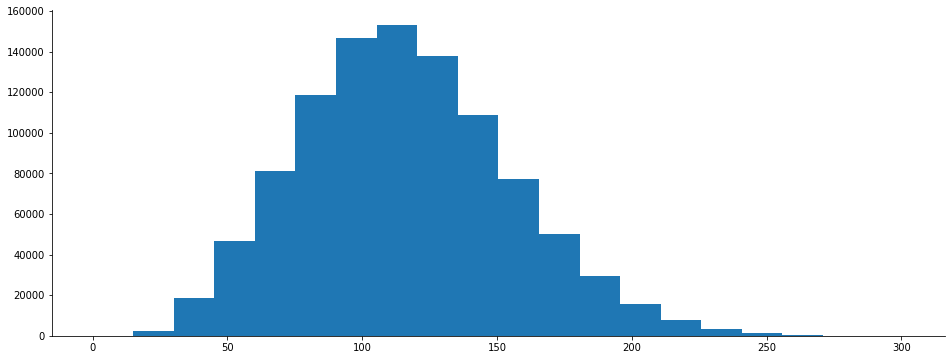

In [26]:
#plot salaries distribution
plt.hist(df_slry['salary'], bins=20);

# **Build models from data wiithout deleting any noises**

In [27]:
#merge train_features and train_salaries for further analysis
df_merged = pd.merge(df,df_slry,how='inner',on='jobId')
df_merged.drop(columns = ['jobId','companyId'], inplace = True)
df_merged = pd.get_dummies(df_merged,columns=['job','dgr','mjr','idstry'])
df_merged.head()

,yearsExp,miles,salary,job_CEO,job_CFO,job_CTO,job_JANITOR,job_JUNIOR,job_MANAGER,job_SENIOR,...,mjr_MATH,mjr_NONE,mjr_PHYSICS,idstry_AUTO,idstry_EDUCATION,idstry_FINANCE,idstry_HEALTH,idstry_OIL,idstry_SERVICE,idstry_WEB
0,10,83,130,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [28]:
#build a linear without cleaning of noises

x_mg = df_merged.drop(columns = 'salary')
y_mg = df_merged['salary']

# Feature Scaling
sc = StandardScaler()
x_mg = sc.fit_transform(x_mg)

# Splitting the dataset into training and testing set (80/20)
xtrain_NC, xtest_NC, ytrain_NC, ytest_NC = train_test_split(x_mg, y_mg, test_size=.20, random_state=0)

#Build a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
lin_NC = LinearRegression().fit(xtrain_NC, ytrain_NC)
y_predNC = lin_NC.predict(xtest_NC)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest_NC, y_predNC))
print('Mean Squared Error:', metrics.mean_squared_error(ytest_NC, y_predNC))
print('Root Mean Squared Error2:', metrics.mean_squared_error(ytest_NC, y_predNC, squared=False))
print('R Square Error:', metrics.r2_score(ytest_NC, y_predNC))


Mean Absolute Error: 15.818830527274368
Mean Squared Error: 383.5062869901593
Root Mean Squared Error2: 19.583316547259283
R Square Error: 0.7436584433271124


In [29]:
#Build a random forest model, and we see the predictions are not very impressive, but slightly improved compare the prediction of above linear regression model
from sklearn.ensemble import RandomForestRegressor


# Splitting the dataset into training and testing set (80/20)
#xtrain_NC, xtest_NC, ytrain_NC, ytest_NC = train_test_split(x_mg, y_mg, test_size=.20, random_state=0)
regressor_NC = RandomForestRegressor(n_estimators=50, random_state=0)
regressor_NC.fit(xtrain_NC, ytrain_NC)
y_predRand_NC = regressor_NC.predict(xtest_NC)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest_NC, y_predRand_NC))
print('Mean Squared Error:', metrics.mean_squared_error(ytest_NC, y_predRand_NC))
print('Root Mean Squared Error:', metrics.mean_squared_error(ytest_NC, y_predRand_NC, squared=False))
print('R Square Error:', metrics.r2_score(ytest_NC, y_predRand_NC))

Mean Absolute Error: 16.76978524353971
Mean Squared Error: 444.5049889372466
Root Mean Squared Error: 21.083286957617556
R Square Error: 0.7028859638591471


**The linear regression model has lower RMSE and higer R square**

# **Checking noises**

In [30]:
#double check salaries distribution 
bins = [0, 50, 100, 150, 200, 250, 300, 301]
labels = ['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '300+']
df_slry['salary2'] = pd.cut(df_slry.salary, bins, labels = labels,include_lowest = True)
#df_output['salary2'] = pd.cut(df_slry.salary, bins, labels = labels,include_lowest = True)
df_slry.groupby('salary2').count()

,jobId,salary
salary2,,
0-50,33444,33444
51-100,330164,330164
101-150,450750,450750
151-200,163505,163505
201-250,21346,21346
251-300,789,789
300+,2,2


In [31]:
# Calculate Z-values
from scipy import stats
df_slry['salary_z'] = np.abs(stats.zscore(df_slry['salary']))
df_slry['salary_z']

0         0.359993
1         0.389014
2         0.540788
3         0.669927
4         1.212312
            ...   
999995    0.724776
999996    1.134828
999997    1.344644
999998    0.850722
999999    0.724776
Name: salary_z, Length: 1000000, dtype: float64

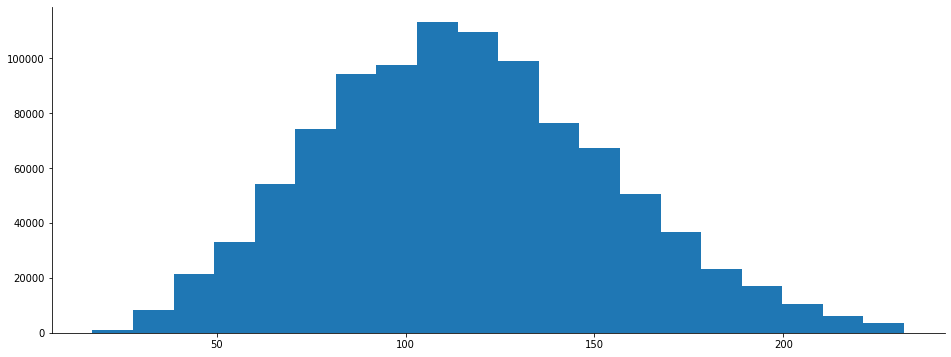

In [32]:
# Filter out outliers by calculated Z-values
df_slry = df_slry[df_slry['salary_z'] <= 3]
# Remove obvs salary  0
df_slry = df_slry[df_slry['salary'] != 0]
df_slry = df_slry.drop('salary_z', axis=1)

# plot salary histgram
plt.hist(df_slry['salary'], bins=20);

In [33]:
#check and see the outliers had been deleted, which was salary great than 250, total 789+2=791 rows
df_slry.groupby('salary2').count()

,jobId,salary
salary2,,
0-50,33439,33439
51-100,330164,330164
101-150,450750,450750
151-200,163505,163505
201-250,18925,18925
251-300,0,0
300+,0,0


In [34]:
#merge train_features and train_salaries for further analysis
df_merge = pd.merge(df,df_slry,how='inner',on='jobId')

In [35]:
#check the distrution for job, degree, major and idstry. And they look good especially for major NONE categorie, we can't remove or replace those NONEs, we treat them as 'other' categorie.
colscheck = ['job', 'dgr', 'mjr', 'idstry']
for i in colscheck:
    print(df_merge.groupby([i])[["salary"]].size())
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")

job
CEO               123175
CFO               123734
CTO               124412
JANITOR           124971
JUNIOR            124589
MANAGER           125040
SENIOR            125868
VICE_PRESIDENT    124994
dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
dgr
BACHELORS      174883
DOCTORAL       173916
HIGH_SCHOOL    236874
MASTERS        174316
NONE           236794
dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
mjr
BIOLOGY         58178
BUSINESS        57938
CHEMISTRY       58628
COMPSCI         58085
ENGINEERING     57796
LITERATURE      58538
MATH            57430
NONE           532058
PHYSICS         58132
dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
idstry
AUTO         142834
EDUCATION    142797
FINANCE      141816
HEALTH       142497
OIL          141651
SERVICE      142578
WEB          142610
dtype: int64
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [36]:
# check "salary" statistics according to job positions, degrees, majors, and idstry. We see some data do not make sense
colscheck = ['job', 'dgr', 'mjr', 'idstry']
for i in colscheck:
    print(df_merge.groupby([i])[["salary"]].agg(["min","max","mean"]))
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")


               salary                 
                  min  max        mean
job                                   
CEO                55  232  144.001218
CFO                51  232  134.898645
CTO                51  232  134.924220
JANITOR            17  189   70.813045
JUNIOR             23  232   95.329523
MANAGER            37  232  115.287404
SENIOR             31  232  105.468419
VICE_PRESIDENT     44  232  125.143999
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
            salary                 
               min  max        mean
dgr                                
BACHELORS       35  232  125.039752
DOCTORAL        45  232  134.573702
HIGH_SCHOOL     18  232  101.861618
MASTERS         38  232  129.850656
NONE            17  232   98.141423
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
            salary                 
               min  max        mean
mjr                                
BIOLOGY         35  232  127.536285
BUSINESS        40  232  134.5363

In [37]:
#CEO,CTO,CFO,VICE_PRESIDENT earn less than 65k?!
df_merge['job'][(df_merge.job.isin(['CEO','CTO','CFO','VICE_PRESIDENT'])) & (df_merge['salary'] <=65)].value_counts()

VICE_PRESIDENT    1143
CFO                271
CTO                257
CEO                 57
Name: job, dtype: int64

In [38]:
#JUNIOR take more than 200k a year? WOW
df_merge['job'][(df_merge.job.isin(['JUNIOR'])) & (df_merge['salary'] >=200)].value_counts()

JUNIOR    174
Name: job, dtype: int64

In [39]:
#JANITOR get more than 200k a year? WOW
df_merge['job'][(df_merge.job.isin(['JANITOR'])) & (df_merge['salary'] >=150)].value_counts()

JANITOR    439
Name: job, dtype: int64

In [40]:
#MANAGER and SENIOR earn less thank 45k?
df_merge['job'][(df_merge.job.isin(['MANAGER','SENIOR'])) & (df_merge['salary'] <=45)].value_counts()

SENIOR     428
MANAGER     48
Name: job, dtype: int64

In [41]:
#year experience check, no obvious problem 
df_merge["yearsExp"].value_counts()

1     40264
15    40235
9     40225
3     40189
8     40113
6     40092
2     40045
7     40042
4     40034
10    40017
5     40010
11    39924
18    39911
17    39902
0     39839
13    39776
14    39773
16    39761
22    39750
20    39690
19    39662
23    39452
21    39448
12    39420
24    39209
Name: yearsExp, dtype: int64

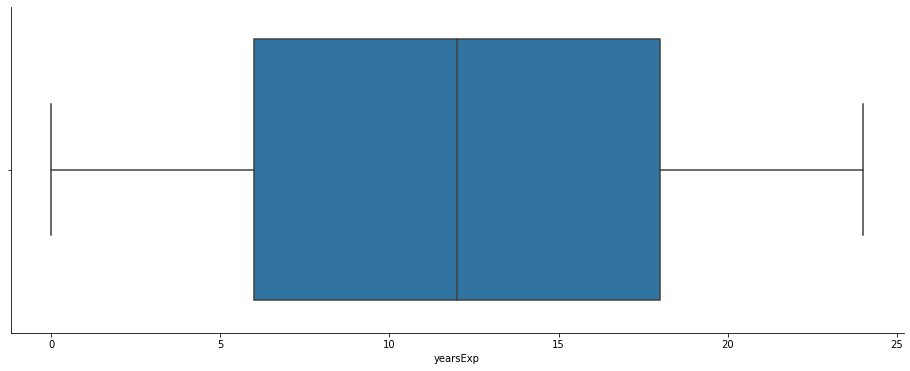

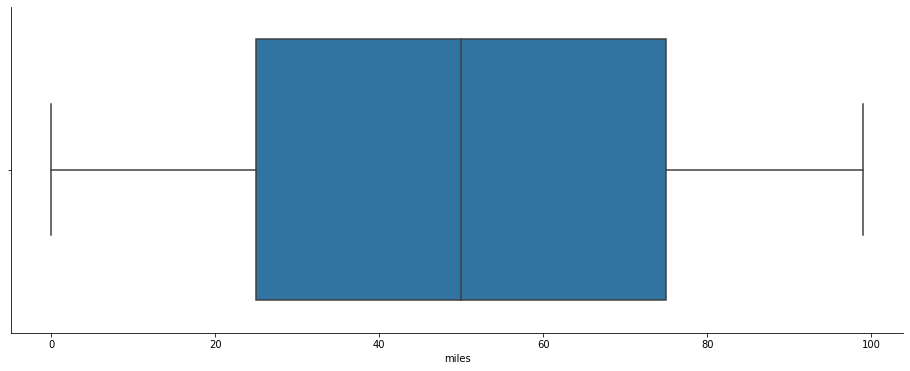

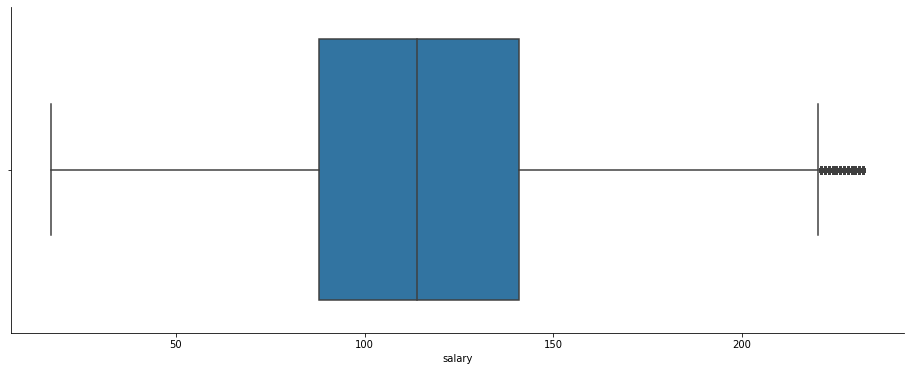

In [42]:
# Function that displays numeric variables as boxplot graphs, respectively
for col in 'yearsExp', 'miles', 'salary':
    sns.boxplot(x= df_merge[col])
    plt.show()

In [43]:
#check numeric variables satistics
quantiles = [.001,.25,0.50,0.75,.99]
display(df_merge.describe(quantiles).T)

,count,mean,std,min,0.1%,25%,50%,75%,99%,max
yearsExp,996783.0,11.964788,7.204888,0.0,0.0,6.0,12.0,18.0,24.0,24.0
miles,996783.0,49.629030,28.855750,0.0,0.0,25.0,50.0,75.0,99.0,99.0
salary,996783.0,115.646598,38.073863,17.0,27.0,88.0,114.0,141.0,210.0,232.0


# **Cleaning the data, one hot encoding, transition,correlation check, noises removal**

In [44]:
#deleted certen outliers based on salary
q_low = df_merge['salary'].quantile(0.001)
q_hi  = df_merge['salary'].quantile(0.99)

df_filtered = df_merge[(df_merge['salary'] < q_hi) & (df_merge['salary'] > q_low)]

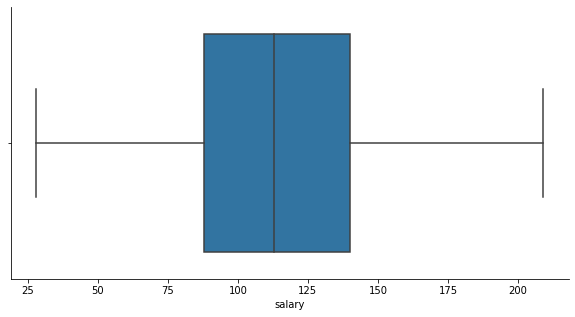

In [45]:
plt.figure(figsize=(10,5))
sns.boxplot(x= df_filtered['salary'])

In [46]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985307 entries, 0 to 996782
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   jobId      985307 non-null  object  
 1   companyId  985307 non-null  object  
 2   job        985307 non-null  object  
 3   dgr        985307 non-null  object  
 4   mjr        985307 non-null  object  
 5   idstry     985307 non-null  object  
 6   yearsExp   985307 non-null  int64   
 7   miles      985307 non-null  int64   
 8   salary     985307 non-null  int64   
 9   salary2    985307 non-null  category
dtypes: category(1), int64(3), object(6)
memory usage: 76.1+ MB


In [47]:
#change miles to range 
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80','80-100']
#for train data
df_filtered['milesR'] = pd.cut(df_filtered.miles, bins, labels = labels)
#for output data
df_output['milesR'] = pd.cut(df_filtered.miles, bins, labels = labels)
#check on train data
df_filtered.groupby('milesR').count()

,jobId,companyId,job,dgr,mjr,idstry,yearsExp,miles,salary,salary2
milesR,,,,,,,,,,
0-20,192566,192566,192566,192566,192566,192566,192566,192566,192566,192566
21-40,196092,196092,196092,196092,196092,196092,196092,196092,196092,196092
41-60,198316,198316,198316,198316,198316,198316,198316,198316,198316,198316
61-80,199083,199083,199083,199083,199083,199083,199083,199083,199083,199083
80-100,189575,189575,189575,189575,189575,189575,189575,189575,189575,189575


In [48]:
#check yearExp and miles information
df_filtered.describe()

,yearsExp,miles,salary
count,985307.000000,985307.000000,985307.000000
mean,11.900961,49.860324,114.665786
std,7.186778,28.805394,36.660106
min,0.000000,0.000000,28.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,113.000000
75%,18.000000,75.000000,140.000000
max,24.000000,99.000000,209.000000


In [49]:
# mutate yearsExp values to 4 levels
df_filtered["yrExp"] = pd.qcut(df_filtered["yearsExp"], 4, labels=["New","Mid","Sr","Exp"])
# mutate yearsExp values to 4 levels for output data
df_output["yrExp"] = pd.qcut(df_output["yearsExp"], 4, labels=["New","Mid","Sr","Exp"])
df_filtered.head()

,jobId,companyId,job,dgr,mjr,idstry,yearsExp,miles,salary,salary2,milesR,yrExp
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130,101-150,80-100,Mid
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101,101-150,61-80,New
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137,101-150,21-40,Mid
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142,101-150,0-20,Mid
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163,151-200,0-20,Mid


In [50]:
#delete above detected outliers since we have enough data and the outliers are not great than 1% of the total
#1.work experience less than 1 year get high salary
df_filtered[(df_filtered['yearsExp'] <= 1) & (df_filtered['salary'] >=200)]
df_filtered = df_filtered[-((df_filtered['yearsExp'] <= 1) & (df_filtered['salary'] >=200))]
#2.CEO,CTO,CFO,VICE_PRESIDENT earn less than 65k?!
df_filtered['job'][(df_filtered.job.isin(['CEO','CTO','CFO','VICE_PRESIDENT'])) & (df_merge['salary'] <=65)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['CEO','CTO','CFO','VICE_PRESIDENT'])) & (df_merge['salary'] <=65))]
#3.MANAGER and SENIOR earn less thank 45k?
df_filtered['job'][(df_filtered.job.isin(['MANAGER','SENIOR'])) & (df_filtered['salary'] <=45)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['MANAGER','SENIOR'])) & (df_filtered['salary'] <=45))]
#4.JANITOR get more than 200k a year? WOW
df_filtered['job'][(df_filtered.job.isin(['JANITOR'])) & (df_filtered['salary'] >=150)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['JANITOR'])) & (df_filtered['salary'] >=150))]
#5.JUNIOR take more than 200k a year? WOW
df_filtered['job'][(df_filtered.job.isin(['JUNIOR'])) & (df_filtered['salary'] >=200)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['JUNIOR'])) & (df_filtered['salary'] >=200))]
#6.work experience less than 1 year get high salary
df_filtered[(df_filtered['yearsExp'] <= 1) & (df_filtered['salary'] >=200)]

,jobId,companyId,job,dgr,mjr,idstry,yearsExp,miles,salary,salary2,milesR,yrExp


In [51]:
#drop columns that will not be used in this analysis
df_filtered.drop(columns=['jobId','companyId','salary2','miles','yearsExp'],inplace=True)
#drop columns for output data
df_output.drop(columns=['jobId','companyId','miles','yearsExp'],inplace=True)
df_filtered.head()

,job,dgr,mjr,idstry,salary,milesR,yrExp
0,CFO,MASTERS,MATH,HEALTH,130,80-100,Mid
1,CEO,HIGH_SCHOOL,NONE,WEB,101,61-80,New
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,137,21-40,Mid
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,142,0-20,Mid
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,163,0-20,Mid


In [52]:
df_filtered.head()

,job,dgr,mjr,idstry,salary,milesR,yrExp
0,CFO,MASTERS,MATH,HEALTH,130,80-100,Mid
1,CEO,HIGH_SCHOOL,NONE,WEB,101,61-80,New
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,137,21-40,Mid
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,142,0-20,Mid
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,163,0-20,Mid


In [53]:
#generate dummies for train and output data
df_filtered = pd.get_dummies(df_filtered,columns=['job','dgr','mjr','idstry','milesR','yrExp'])
df_output = pd.get_dummies(df_output,columns=['job','dgr','mjr','idstry','milesR','yrExp'])

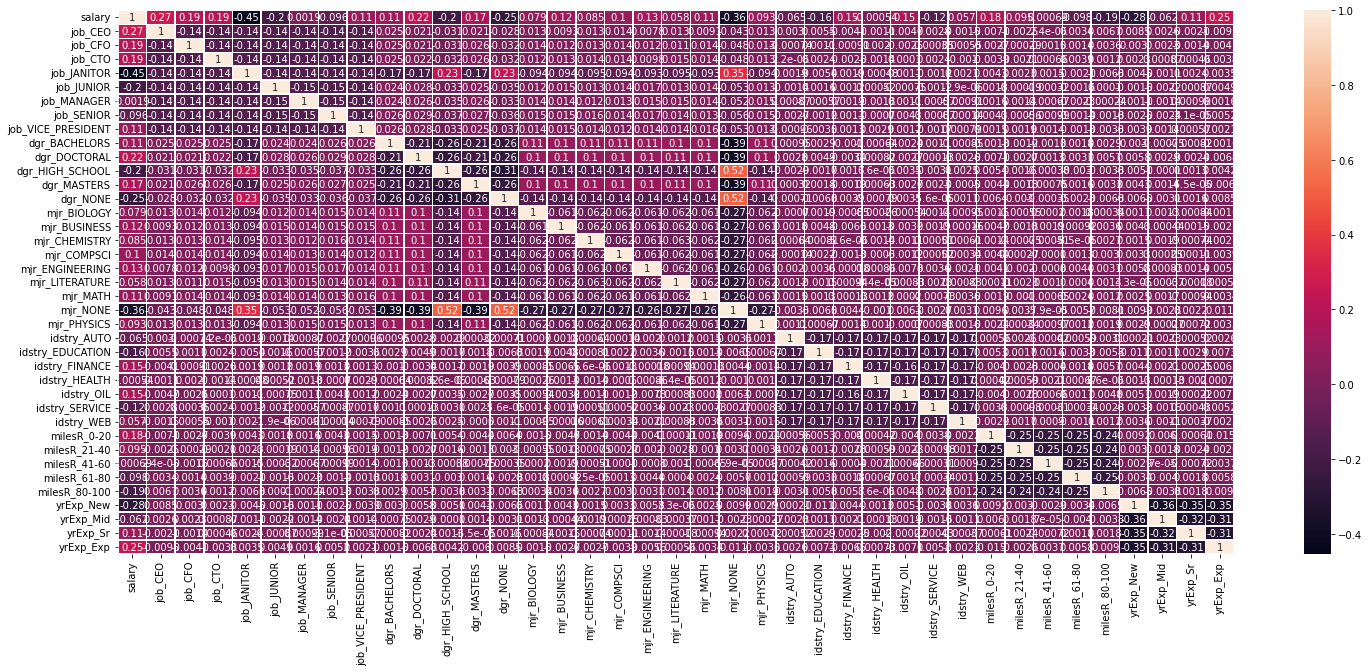

In [54]:
#correlation check
#df_filtered.corr()
#correlation heatmap, the largest correlation is 0.52, so no move needed

fig, ax = plt.subplots(figsize=(25,10)) 
sns.heatmap(df_filtered.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

# **Model uning: Building models using cleaned data**

In [55]:
x = df_filtered.drop(columns = 'salary')
y = df_filtered['salary']
colNames = x.columns
# Feature Scaling
sc = StandardScaler()
x = sc.fit_transform(x)
# Splitting the dataset into training and testing set (80/20)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.20, random_state=0)

In [57]:
#Build a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
linreg = LinearRegression().fit(xtrain, ytrain)
y_predlin = linreg.predict(xtest)


print('Mean Absolute Error: %.3f' %(metrics.mean_absolute_error(ytest, y_predlin)))
print('Mean Squared Error:%.3f' %(metrics.mean_squared_error(ytest, y_predlin)))
print('Root Mean Squared Error2:%.3f' %(metrics.mean_squared_error(ytest, y_predlin, squared=False)))
print('R Square Error:%.3f' %(metrics.r2_score(ytest, y_predlin)))

Mean Absolute Error: 15.686
Mean Squared Error:372.484
Root Mean Squared Error2:19.300
R Square Error:0.721


In [58]:
#Build a random forest model, and we see the predictions are not very impressive, but slightly improved compare the prediction of above linear regression model
from sklearn.ensemble import RandomForestRegressor

# Feature Scaling
# sc = StandardScaler()
# x = sc.fit_transform(x)
# Splitting the dataset into training and testing set (80/20)
# xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.20, random_state=0)
regressor = RandomForestRegressor(n_estimators=50, random_state=0)
regressor.fit(xtrain, ytrain)
y_predrand = regressor.predict(xtest)

print('Mean Absolute Error: %.3f' %(metrics.mean_absolute_error(ytest, y_predlin)))
print('Mean Squared Error:%.3f' %(metrics.mean_squared_error(ytest, y_predlin)))
print('Root Mean Squared Error2:%.3f' %(metrics.mean_squared_error(ytest, y_predlin, squared=False)))
print('R Square Error:%.3f' %(metrics.r2_score(ytest, y_predlin)))

Mean Absolute Error: 15.686
Mean Squared Error:372.484
Root Mean Squared Error2:19.300
R Square Error:0.721


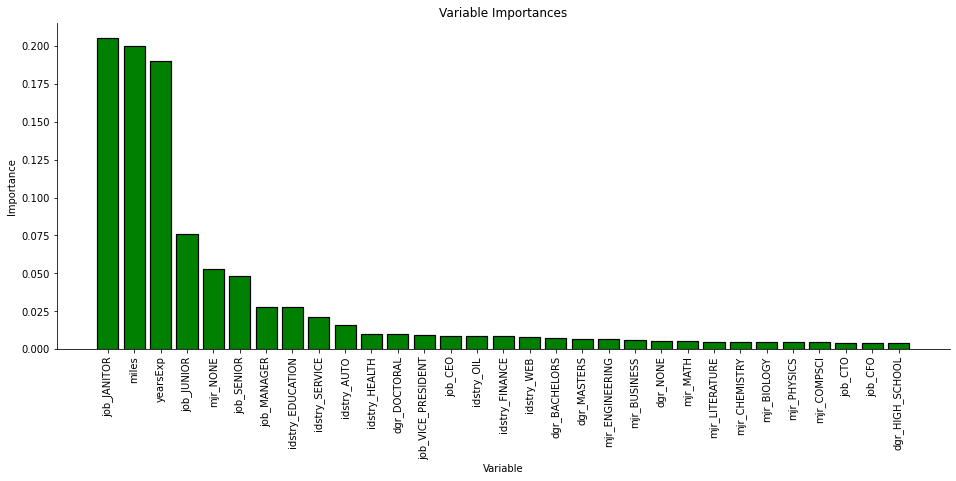

In [78]:
#sort importance to a df, and we can visually see the longer the bar, the higher the importance to the predict variable salary
df_imp = pd.DataFrame({'Feature_names':colNames, 'Importances':regressor.feature_importances_})
df_imp.sort_values(by='Importances', ascending = False, inplace=True)
df_imp.reset_index(drop=True, inplace=True)

# Make a bar chart
plt.bar(df_imp['Feature_names'], df_imp['Importances'], orientation = 'vertical', color = 'g', edgecolor = 'k', linewidth = 1.2)
plt.xticks(df_imp['Feature_names'], rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

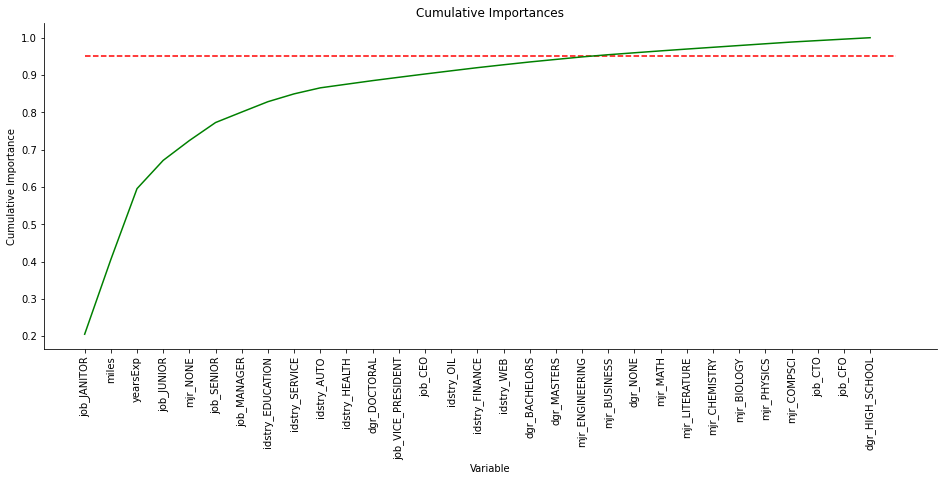

In [79]:
#plot cumulative importances so we can visually see which variables reach 95% of importance
feature_importances = df_imp.to_numpy()

sorted_importances = [imp[1] for imp in feature_importances]
sorted_features = [imp[0] for imp in feature_importances]

cumulative_importances = np.cumsum(sorted_importances)
plt.plot(df_imp['Feature_names'], cumulative_importances, 'g-')
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

plt.xticks(df_imp['Feature_names'], sorted_features, rotation = 'vertical')
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [80]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 21


**After transforming and cleaning above mentioned data, both linear regression and random forest got worsened. So, next step is find which part cased this problem and how to get a better model.**

# **Final model: linear regression model, with full code**

In [88]:
#import libraries，fig size setting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from warnings import filterwarnings
filterwarnings('ignore')

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

#files location
path = '/content/drive/MyDrive/data/'
train_features = path+'train_features.csv'
train_salaries = path+'train_salaries.csv'
test_features = path+'test_features.csv'

#read train features, train salaries and test features
df = pd.read_csv(train_features,sep=",")
df_slry = pd.read_csv(train_salaries,sep=",")
df_output = pd.read_csv(test_features,sep=",")
df_output2 = df_output['jobId']
#simplify columns name to make easier dummies
colNames = ['jobId','companyId','job','dgr','mjr','idstry', 'yearsExp', 'miles']
df.columns=colNames
df_output.columns=colNames


#merge train_features and train_salaries for further analysis
df_merge = pd.merge(df,df_slry,how='inner',on='jobId')

df_filtered = df_merge
#delete above detected outliers since we have enough data and the outliers are not great than 1% of the total
#1.work experience less than 1 year get high salary
df_filtered[(df_filtered['yearsExp'] <= 1) & (df_filtered['salary'] >=200)]
df_filtered = df_filtered[-((df_filtered['yearsExp'] <= 1) & (df_filtered['salary'] >=200))]
#2.CEO,CTO,CFO,VICE_PRESIDENT earn less than 65k?!
df_filtered['job'][(df_filtered.job.isin(['CEO','CTO','CFO','VICE_PRESIDENT'])) & (df_merge['salary'] <=65)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['CEO','CTO','CFO','VICE_PRESIDENT'])) & (df_merge['salary'] <=65))]
#3.MANAGER and SENIOR earn less thank 45k?
df_filtered['job'][(df_filtered.job.isin(['MANAGER','SENIOR'])) & (df_filtered['salary'] <=45)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['MANAGER','SENIOR'])) & (df_filtered['salary'] <=45))]
#4.JANITOR get more than 200k a year? WOW
df_filtered['job'][(df_filtered.job.isin(['JANITOR'])) & (df_filtered['salary'] >=150)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['JANITOR'])) & (df_filtered['salary'] >=150))]
#5.JUNIOR take more than 200k a year? WOW
df_filtered['job'][(df_filtered.job.isin(['JUNIOR'])) & (df_filtered['salary'] >=200)].value_counts()
df_filtered = df_filtered[-((df_filtered.job.isin(['JUNIOR'])) & (df_filtered['salary'] >=200))]
#6.work experience less than 1 year get high salary
df_filtered[(df_filtered['yearsExp'] <= 1) & (df_filtered['salary'] >=200)]


# test which step cause accuricy reduct
#generate dummies for train and output data
df_filtered = pd.get_dummies(df_filtered,columns=['job','dgr','mjr','idstry'])
df_output = pd.get_dummies(df_output,columns=['job','dgr','mjr','idstry'])

df_filtered.drop(columns=['jobId','companyId'],inplace=True)
df_output.drop(columns=['jobId','companyId'],inplace=True)

x = df_filtered.drop(columns = 'salary')
y = df_filtered['salary']
colNames = x.columns
# Feature Scaling
sc = StandardScaler()
x = sc.fit_transform(x)
# Splitting the dataset into training and testing set (80/20)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.20, random_state=0)
#Build a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
linreg = LinearRegression().fit(xtrain, ytrain)
y_predlin = linreg.predict(xtest)


print('Mean Absolute Error: %.3f' %(metrics.mean_absolute_error(ytest, y_predlin)))
print('Mean Squared Error:%.3f' %(metrics.mean_squared_error(ytest, y_predlin)))
print('Root Mean Squared Error2:%.3f' %(metrics.mean_squared_error(ytest, y_predlin, squared=False)))
print('R Square Error:%.3f' %(metrics.r2_score(ytest, y_predlin)))

Mean Absolute Error: 15.784
Mean Squared Error:381.908
Root Mean Squared Error2:19.542
R Square Error:0.744


In [69]:
#get linear regression intercept and coefficients
params = np.append(linreg.intercept_,linreg.coef_)
params

array([ 1.16148811e+02,  1.44124306e+01, -1.14700395e+01,  2.85277536e+12,
        2.84702858e+12,  2.85378506e+12,  2.85138231e+12,  2.85025324e+12,
        2.85667341e+12,  2.86044489e+12,  2.84704827e+12, -3.20475139e+12,
       -3.20378786e+12, -3.57870022e+12, -3.20379506e+12, -3.57371740e+12,
       -3.77428523e+11, -3.77695320e+11, -3.78935172e+11, -3.77470984e+11,
       -3.77843772e+11, -3.78358231e+11, -3.75691473e+11, -8.02408791e+11,
       -3.77549824e+11, -5.16046725e+11, -5.14275710e+11, -5.15853883e+11,
       -5.15969907e+11, -5.15697094e+11, -5.15037255e+11, -5.16636428e+11])

In [85]:
#let's take a look at the prediction compare the validation data. Not very impressive, but slightly improved compare the prediction of above linear regression model
y = pd.DataFrame(y_predlin[:20],columns=['y_pred'],dtype=int)
pd.concat([ytest[:20].reset_index(drop=True), y], axis=1)

,salary,y_pred
0,203,150
1,110,112
2,79,92
3,130,113
4,112,122
5,112,142
6,104,79
7,100,78
8,147,126
9,134,111


In [89]:
#write jobId and salary to csv file test_salaries and compress it
y_output = regressor.predict(df_output)
y = pd.DataFrame(y_output,columns=['salary'],dtype=int)
output = pd.concat([df_output2.reset_index(drop=True), y], axis=1)
compression_opts = dict(method='zip',
                        archive_name='test_salaries.csv')  
output.to_csv('test_salaries.zip', index=False,
          compression=compression_opts)  
output.head()

,jobId,salary
0,JOB1362685407687,130
1,JOB1362685407688,123
2,JOB1362685407689,142
3,JOB1362685407690,130
4,JOB1362685407691,136
